In [1]:
# Importaciones para manejo de datos y dataframes
import numpy as np
from numpy.random import seed
import pandas as pd

# Importaciones para manejo de archivos y llamadas al OS
import os as os
import warnings

# Importaciones para manejo de gráficos
import pylab as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.neighbors import LocalOutlierFactor

# Metemos un gridsearch
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.impute import SimpleImputer


from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector,VarianceThreshold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile
# Según el criterio chi-squared dustribution for it to have three features
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import SelectFromModel


# No mostrar warnings de versiones anteriores
warnings.filterwarnings('ignore')

In [2]:
# Cargamos csv con los datos de train
df_train = pd.read_csv("../data_raw/training_data.csv", sep=",", header=0, na_values=['?', '', 'NA'])
# Cargamos csv con los datos de test
df_test = pd.read_csv("../data_raw/test_data.csv", sep=",", header=0, na_values=['?', '', 'NA'])

In [3]:
## ENCODING

df_train_num = df_train.copy()
df_test_num = df_test.copy()

# 1. "OrdinalEncoder" para X24
orden_x24 = ['VLOW', 'LOW', 'MED', 'HIGH', 'VHIGH']

ordinal_encoder_x24 = OrdinalEncoder(categories=[orden_x24], dtype=int)

df_train_num['X24'] = ordinal_encoder_x24.fit_transform(df_train_num[['X24']])
df_test_num['X24'] = ordinal_encoder_x24.transform(df_test_num[['X24']])

# 2. "OrdinalEncoder" para X25
orden_x25 = ['NO', 'YES']

ordinal_encoder_x25 = OrdinalEncoder(categories=[orden_x25], dtype=int)

df_train_num['X25'] = ordinal_encoder_x25.fit_transform(df_train_num[['X25']])
df_test_num['X25'] = ordinal_encoder_x25.transform(df_test_num[['X25']])

# Si es VTKGN 1 else 0
# Ya que la la clase está muy desbalanceada
df_train_encoded = df_train_num.copy()
df_test_encoded = df_test_num.copy()

df_train_encoded.loc[df_train_num['X30'] == 'VTKGN', 'X30'] = 1
df_train_encoded.loc[df_train_num['X30'] != 'VTKGN', 'X30'] = 0

df_test_encoded.loc[df_test_num['X30'] == 'VTKGN', 'X30'] = 1
df_test_encoded.loc[df_test_num['X30'] != 'VTKGN', 'X30'] = 0

df_train_encoded['X30'] = pd.to_numeric(df_train_encoded['X30'])
df_test_encoded['X30'] = pd.to_numeric(df_train_encoded['X30']) 


In [4]:
# df_train_encoded
# df_test_encoded

In [5]:
## PREPROCESAMIENTO

df_train = df_train_encoded
df_test = df_test_encoded


# Preprocesamiento para TRAIN
df_final_train = df_train.drop(['ID','RATE'], axis=1, inplace=False)
train_ID = df_train['ID'].copy()
train_RATE = df_train['RATE'].copy()

# Preprocesamiento para TEST
df_final_test = df_test.drop('ID', axis=1, inplace=False)
test_ID = df_test['ID'].copy()



<Axes: xlabel='column', ylabel='value'>

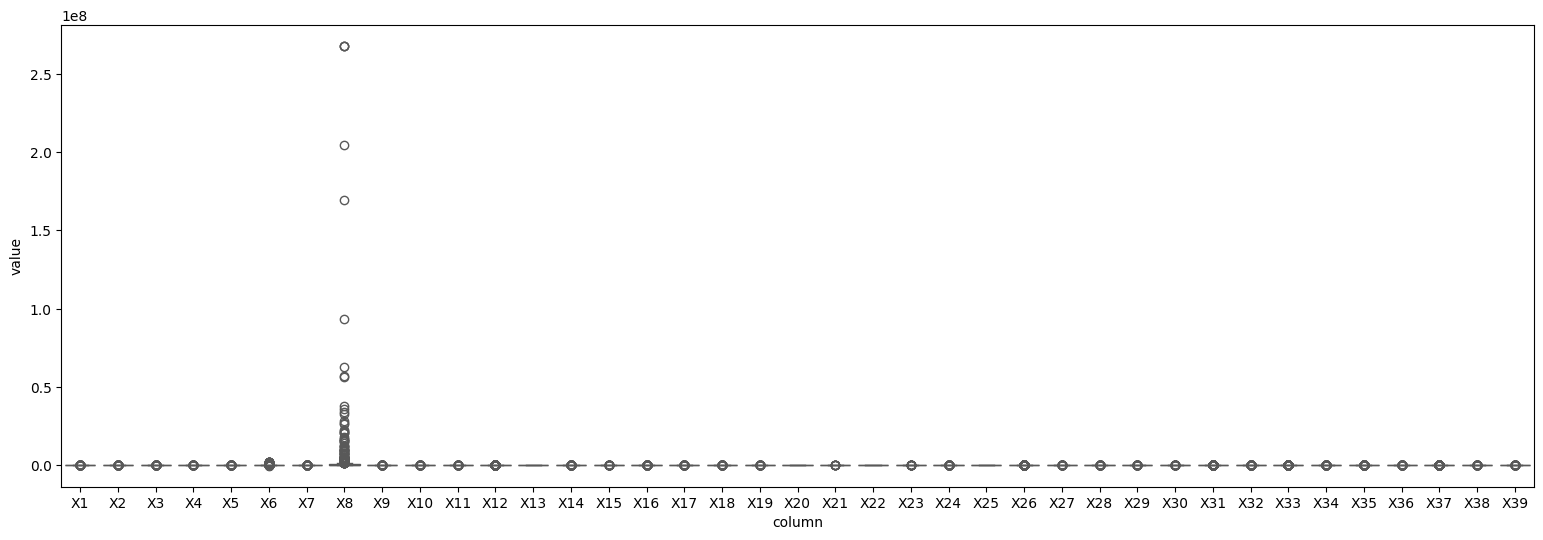

In [6]:

df_train_copy = df_final_train.copy()
df_test_copy = df_final_test.copy()

# Escala raíz cuadrada a las que se dispersan mucho
df_train_copy[['X1','X2','X3','X4','X5','X7','X10','X11']] = np.sqrt(df_train_copy[['X1','X2','X3','X4','X5','X7','X10','X11']])
df_test_copy[['X1','X2','X3','X4','X5','X7','X10','X11']] = np.sqrt(df_test_copy[['X1','X2','X3','X4','X5','X7','X10','X11']])

df_melted = df_train_copy.melt(var_name='column')

plt.figure(figsize=(19,6))
sns.boxplot(data=df_melted, color="#3BA3EC", x="column", y="value")

In [7]:
# df_train_copy
# df_test_copy

In [8]:
#1. Quitar outliers

modelo_isof = IsolationForest(
                n_estimators  = 1000,
                max_samples   ='auto',
                contamination = 0.1,
                n_jobs        = -1,
                random_state  = 123,
            )

df_no_na = df_train_copy.dropna(axis=0, inplace=False)

modelo_isof.fit(X=df_no_na)
clasificacion_predicha = modelo_isof.predict(X=df_no_na)
clasificacion_predicha

df_no_na['clasificacion_predicha'] = clasificacion_predicha
indices_outliers = df_no_na.index[df_no_na['clasificacion_predicha'] == -1].tolist()

indices_outliers

df_no_outliers = df_train_copy.drop(index=indices_outliers)

# Ahora, imputo sobre el dataset sin outliers
imp_train = KNNImputer(n_neighbors=5).fit(df_no_outliers)
df_train_imp = pd.DataFrame(imp_train.transform(df_train_copy), columns=df_train_copy.columns, index=df_train_copy.index)

# imp_train = SimpleImputer(missing_values=np.nan, strategy='median').fit(df_no_outliers) #most_frequent
# df_train_imp = pd.DataFrame(imp_train.transform(df_train_copy), columns=df_train_copy.columns, index=df_train_copy.index)

# Hago lo mismo para test

modelo_isof_test = IsolationForest(
                n_estimators  = 1000,
                max_samples   ='auto',
                contamination = 0.1,
                n_jobs        = -1,
                random_state  = 123,
            )

df_no_na_test = df_test_copy.dropna(axis=0, inplace=False)

modelo_isof_test.fit(X=df_no_na_test)
clasificacion_predicha = modelo_isof_test.predict(X=df_no_na_test)
clasificacion_predicha

df_no_na_test['clasificacion_predicha'] = clasificacion_predicha
indices_outliers = df_no_na_test.index[df_no_na_test['clasificacion_predicha'] == -1].tolist()

indices_outliers

df_no_outliers_test = df_test_copy.drop(index=indices_outliers)


imp_test = KNNImputer(n_neighbors=5).fit(df_no_outliers_test)
df_test_imp = pd.DataFrame(imp_test.transform(df_test_copy), columns=df_test_copy.columns, index=df_test_copy.index)

#Imputamos con mediana

# imp_test = SimpleImputer(missing_values=np.nan, strategy='median').fit(df_no_outliers_test)
# df_test_imp = pd.DataFrame(imp_test.transform(df_test_copy), columns=df_test_copy.columns, index=df_test_copy.index)



In [9]:
# df_train_imp
# df_test_imp

In [10]:
# # 4. Escalamos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_train_imp.to_numpy())
df_scaled = pd.DataFrame(df_scaled,index=df_train_imp.index, columns=[df_train_imp.columns])

df_scaled_test = scaler.transform(df_test_imp.to_numpy())
df_scaled_test = pd.DataFrame(df_scaled_test,index=df_test_imp.index, columns=[df_test_imp.columns])


# # 5. Componemos las columnas
columns = ['ID']
columns = np.append(columns, df_train_copy.columns)
columns = np.append(columns, 'RATE')

result_df_train = pd.merge(train_ID, df_scaled, left_index=True, right_index=True)
result_df_train = pd.merge(result_df_train, train_RATE, left_index=True, right_index=True)
result_df_train.columns = columns

columns = ['ID']
columns = np.append(columns, df_test_copy.columns)

result_df_test = pd.merge(test_ID, df_scaled_test, left_index=True, right_index=True)
result_df_test.columns = columns
  

In [11]:
# 6. ENTRENAMIENTO

X = result_df_train.drop(['ID','RATE'], inplace=False, axis=1)
y = result_df_train['RATE']

In [24]:
from sklearn import datasets, cluster
agglo = cluster.FeatureAgglomeration(n_clusters=30)
agglo.fit(X)
X_reduced = agglo.transform(X)
X_reduced.shape

cols = X_reduced.shape[1]
selected_columns = [f"X{i+1}" for i in range(X_reduced.shape[1])]
X_train_out = pd.DataFrame(data=X_reduced, columns=selected_columns)
X_train_out.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30
0,-0.569789,-0.273938,-0.606988,0.009826,-0.419725,0.166728,0.194653,-1.546747,-0.395754,-0.960070,...,-1.765120,-0.133900,-0.302314,0.817835,-0.245895,-0.760183,-0.980326,0.653733,0.617866,-0.295569
1,0.246320,0.264269,-0.019182,0.137003,-0.022127,0.629884,0.445469,-0.065402,-0.248058,0.280970,...,0.624288,0.268846,0.873161,0.479746,0.601180,-0.826798,1.020069,0.318575,0.228421,1.121953
2,-0.351909,0.096351,-0.413235,0.120433,0.005865,0.384696,0.455513,-0.646282,0.261661,-0.324111,...,-0.247943,0.160995,-0.226277,-0.565167,-1.092970,-0.477734,-0.980326,-0.481116,0.181476,0.070365
3,-0.330164,-0.186448,-0.487710,0.174265,-0.171761,0.362279,0.339223,0.183166,-0.389402,-0.106855,...,-0.594699,0.108577,-0.052308,-0.321505,1.448255,-0.749524,-0.980326,-0.088302,-0.584852,0.474024
4,-0.406844,0.102464,-0.554250,0.125648,0.198838,0.508391,0.656642,-0.815013,-0.164305,-0.141778,...,-0.313992,0.179850,-0.194619,-0.518051,0.601180,0.969149,-0.980326,-0.279084,-0.052919,0.107147


In [19]:
clf = RandomForestClassifier(n_estimators = 200)
clf.fit(X, y)

RandomForestClassifier(n_estimators=200)

In [20]:
clf.feature_importances_

array([0.02729905, 0.02791031, 0.02517962, 0.03572132, 0.0238778 ,
       0.02263508, 0.0177136 , 0.02314326, 0.0170159 , 0.02468207,
       0.02606512, 0.01937413, 0.019927  , 0.0167768 , 0.09746383,
       0.03638593, 0.04788884, 0.04729404, 0.0193277 , 0.02097116,
       0.04667001, 0.04318945, 0.0225639 , 0.00871017, 0.00746974,
       0.0190635 , 0.02863732, 0.01584562, 0.02132805, 0.00185824,
       0.02043317, 0.01761774, 0.02178589, 0.02219553, 0.02943728,
       0.01968856, 0.02105611, 0.0189188 , 0.01687836])

In [21]:
clf.feature_importances_  

model = SelectFromModel(clf, prefit=True, threshold=-np.inf, max_features=20)
X_reduced = model.transform(X)


selected_columns = X.columns[model.get_support()]
X_train_in = pd.DataFrame(data=X_reduced, columns=selected_columns)
selected_columns


selected_columns = [f"X{i+1}" for i in range(10)]
selected_columns
X_train_out = pd.DataFrame(data=X_reduced, columns=selected_columns)

Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8', 'X10', 'X11', 'X15', 'X16',
       'X17', 'X18', 'X21', 'X22', 'X23', 'X27', 'X33', 'X34', 'X35'],
      dtype='object')

In [88]:

# Extracción de características
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X, y)
clf.feature_importances_  

model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)


selected_columns = X.columns[model.get_support()]
X_new_df = pd.DataFrame(data=X_new, columns=selected_columns)

X_feat_selec = X_new_df

In [91]:
# X_feat_selec = X
# y

X_train_split, X_validacion, y_train_split, y_validacion = train_test_split(X_feat_selec, y, test_size=0.3, random_state = 32, shuffle=True)

# for i in np.arange(1,12):
print(sorted(Counter(y_train_split).items()))
# [('A', 51), ('B', 274), ('C', 160), ('D', 149)]

k=9
# Estrategias de oversampling y undersampling la mayority
over = SMOTE(sampling_strategy = {'A': 70}, k_neighbors=k)
under = RandomUnderSampler(sampling_strategy = {'B': 150, 'C':120, 'D':120})

steps = [('u', under)]

pipeline = Pipeline(steps=steps)

X_resampled, y_resampled = pipeline.fit_resample(X_train_split, y_train_split)


# Aplicamos algoritmo
# X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state = 32, shuffle=True)

param_grid_knn = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31],                                   
    'algorithm': ['ball_tree', 'kd_tree', 'brute', 'auto'],          
    'metric': ['minkowski', 'euclidean', 'manhattan', 'chebyshev'],
    'weights': ['uniform','distance']
}


kNNModel_grid = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid_knn, verbose=0, cv=10, n_jobs=-1, scoring='accuracy')
kNNModel_grid.fit(X_resampled, y_resampled)

print(f"Mejores parámetros {kNNModel_grid.best_estimator_}")
#print(f"K value SMOTE {k}")
# print(f"Acc en GridSearch {kNNModel_grid.best_score_}")
y_pred = kNNModel_grid.predict(X_validacion)

# print("Matriz de confusión:")
# print(confusion_matrix(y_validacion, y_pred))
acc = accuracy_score(y_validacion, y_pred)
print(f"Acc. en Validación: {acc}\n")

if(acc > 0.654):
    print("Escrito resultado en csv\n")
    test_val = result_df_test.drop('ID', inplace=False, axis=1)
    test_ID = result_df_test['ID'].copy()
    y_pred = kNNModel_grid.predict(test_val)

    result_df = pd.DataFrame({'ID': test_ID, 'TARGET':y_pred})
    result_df.to_csv('../results/submit.csv', index=False, sep=",")
        
        



[('A', 51), ('B', 274), ('C', 160), ('D', 149)]
Mejores parámetros KNeighborsClassifier(algorithm='ball_tree', metric='manhattan', n_neighbors=19,
                     weights='distance')
Acc. en Validación: 0.625

